## Data Acquisition and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import holidays
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression,f_regression

In [2]:
china_CO2_hist = pd.read_csv('china_carbon_co2_emissions.csv')
china_CO2_hist['date'] = pd.to_datetime(china_CO2_hist['date']).dt.date
china_CO2_hist = china_CO2_hist.set_index('date')

china_gdp = (
    pd.read_csv('china_gdp.csv', usecols=['TIME', 'Value'])
    .rename(columns={'TIME': 'Date', 'Value': 'GDP ($)'})
    .set_index('Date')
)

china_energy_capita = (
    pd.read_csv('china_Power_Consumptiom_per_capita.csv')
    .rename(columns={'Power Consumption per capita (kWh)': 'Energy per Capita (kWh)'})
    .set_index('date')
)

china_renewable_stat = (
    pd.read_csv('china-renewable-energy-statistics.csv')
    .assign(year=lambda df: pd.to_datetime(df['date']).dt.year)
    .drop(columns=['date'])
    .rename(columns={'Annual Change': 'Renewable Annual Change'})
    .set_index('year')
)

china_population = (
    pd.read_csv('china-population.csv')
    .assign(year=lambda df: pd.to_datetime(df['date']).dt.year)
    .drop(columns=['date'])
    .set_index('year')
)

china_inflation = (
    pd.read_csv('china_inflation.csv', usecols=['TIME', 'Value'])
    .rename(columns={'TIME': 'Date', 'Value': 'Inflation'})
    .set_index('Date')
)

china_data = (
    china_gdp
    .join(china_energy_capita, how='outer')
    .join(china_renewable_stat, how='outer')
    .join(china_population, how='outer')
    .join(china_inflation, how='outer')
    .dropna()
)

china_renewable=pd.read_csv('china_renewable%.csv')

In [3]:
def clean_country_data(country):
    # Read in the CSV files
    gdp = pd.read_csv(f'{country}_gdp.csv')
    energy_capita = pd.read_csv(f'{country}_Power_Consumptiom_per_capita.csv')
    population = pd.read_csv(f'{country}-population.csv')
    inflation = pd.read_csv(f'{country}_inflation.csv')

    
    # Clean the GDP data
    gdp = gdp.rename(columns={'TIME': 'Date', 'Value': 'GDP ($)'})
    gdp = gdp[['Date', 'GDP ($)']]
    gdp = gdp.set_index('Date')
    
    # Clean the energy consumption data
    energy_capita = energy_capita.set_index('date')
    
    # Clean the population data
    population['year'] = pd.to_datetime(population['date']).dt.year
    population = population.set_index('year')
    population = population.drop('date', axis=1)
    
    # Clean the inflation data
    inflation = inflation[['TIME', 'Value']]
    inflation = inflation.rename(columns={'Value': 'Inflation'})
    inflation = inflation.set_index('TIME')
    
    # Merge the data
    data = pd.merge(gdp, energy_capita, left_index=True, right_index=True, how='outer')
    data = pd.merge(data, population, left_index=True, right_index=True, how='outer')
    data = pd.merge(data, inflation, left_index=True, right_index=True, how='outer')
    
    # Rename the annual growth rate column
    data['Annual Growth Rate'] = data[' Annual % Change']
    data = data.drop(' Annual % Change', axis=1)
    
    # Drop rows with missing values
    data = data.dropna()
    
    return data


In [4]:
germany_data = clean_country_data('germany')
portugal_data = clean_country_data('portugal')
austria_data = clean_country_data('austria')
norway_data = clean_country_data('norway')
denmark_data = clean_country_data('denmark')
spain_data = clean_country_data('spain')
france_data = clean_country_data('france')
uk_data= clean_country_data('uk')
italy_data= clean_country_data('italy')

In [5]:
spain_data

,GDP ($),kWh per Capita,Population,Inflation,Annual Growth Rate
1990,13520.860458,3537.0,38889889,6.721821,0.11
1991,14308.610814,3608.0,38997063,5.934214,0.28
1992,14736.224104,3691.0,39202251,5.924531,0.53
1993,14897.342444,3639.0,39420546,4.569072,0.56
1994,15550.196517,3756.0,39623725,4.718413,0.52
1995,16290.472360,3915.0,39814573,4.673804,0.48
1996,16982.180204,4009.0,39996473,3.558843,0.46
1997,17916.032165,4324.0,40180050,1.971078,0.46
1998,19101.544588,4479.0,40362357,1.834330,0.45
1999,19962.792109,4821.0,40542232,2.310345,0.45


## Comparison

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

features = ['GDP ($)', 'Inflation', 'Annual Growth Rate', 'kWh per Capita']




# Drop rows with NaN values for any of the selected features
data = {
    'Germany': germany_data,
    'Portugal': portugal_data,
    'Denmark': denmark_data,
    'Norway': norway_data,
    'Austria': austria_data,
    'Spain': spain_data,
    'France': france_data,
    'Uk': uk_data,
    'Italy': italy_data
}
    
# Create a dictionary to store the similarities
similarities = {}

for country, country_data in data.items():
    #Finding common dates between China's data and the data for the current country
    common_dates = china_data.index.intersection(country_data.index)
    #Create new dataframes that only have the rows from China's data and the current country's data that correspond to the common dates
    china_common = china_data.loc[common_dates]
    country_common = country_data.loc[common_dates]
    #Create Vectors
    china_array = china_common[features].to_numpy().reshape(1, -1)
    country_array = country_common[features].to_numpy().reshape(1, -1)
    #Calculate cosine similarity
    similarity = cosine_similarity(china_array, country_array)[0][0]
    similarities[country] = similarity

most_similar_country, similarity_score = max(similarities.items(), key=lambda x: x[1])
print(f"The most similar country to China is {most_similar_country} with a cosine similarity score of {similarity_score:.3f}")

The most similar country to China is Austria with a cosine similarity score of 0.927


In [7]:
china_renewable=pd.read_csv('china_renewable%.csv')
germany_renewable=pd.read_csv('germany_renewable%.csv')
portugal_renewable=pd.read_csv('portugal_renewable%.csv')
denmark_renewable=pd.read_csv('denmark_renewable%.csv')
austria_renewable=pd.read_csv('austria_renewable%.csv')
norway_renewable=pd.read_csv('norway_renewable%.csv')
france_renewable=pd.read_csv('france_renewable%.csv')
uk_renewable=pd.read_csv('uk_renewable%.csv')
spain_renewable=pd.read_csv('spain_renewable%.csv')
italy_renewable=pd.read_csv('italy_renewable%.csv')
poland_renewable=pd.read_csv('poland_renewable%.csv')


In [8]:
df_renewable=pd.merge(portugal_renewable,germany_renewable,how='outer')
df_renewable=pd.merge(df_renewable, denmark_renewable,how='outer')
df_renewable=pd.merge(df_renewable, norway_renewable,how='outer')
df_renewable=pd.merge(df_renewable, austria_renewable,how='outer')
df_renewable=pd.merge(df_renewable, france_renewable,how='outer')
df_renewable=pd.merge(df_renewable, spain_renewable,how='outer')
df_renewable=pd.merge(df_renewable, uk_renewable,how='outer')
df_renewable=pd.merge(df_renewable, italy_renewable,how='outer')
df_renewable=pd.merge(df_renewable, poland_renewable,how='outer')


df_renewable=df_renewable.set_index('Country', drop=True)
df_renewable

C:\Users\lmnro\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1219: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(
C:\Users\lmnro\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1207: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(
C:\Users\lmnro\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1207: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(
C:\Users\lmnro\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1207: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(
C:\Users\lmnro\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1207: UserWarning: You are merging on int and float columns where th

,Nuclear %,Hydro %,Wind %,Solar PV %,Bio Energy %,Geothermal %
Country,,,,,,
Portugal,0.00,47.04,37.78,7.74,7.04,0.4
Germany,23.18,6.90,38.02,17.62,14.18,0.1
Denmark,0.00,0.14,70.17,3.78,25.91,0.0
Norway,0.00,95.65,4.35,0.00,0.00,0.0
Austria,0.00,69.40,14.80,10.20,5.70,0.0
France,76.16,11.80,7.40,2.87,1.77,0.0
Spain,34.32,20.90,32.84,11.94,0.00,0.0
UK,28.86,3.35,49.91,8.19,9.69,0.0
Italy,0.00,14.10,5.80,8.10,50.60,21.4


In [9]:
def plot_similar_country(df_renewable, china_renewable):
    # Calculate Euclidean distance between China and each country in the dataframe
    distances = {}
    for country in df_renewable.index:
        values = df_renewable.loc[country].values
        distance = np.linalg.norm(china_renewable - values)
        distances[country] = distance

    # Find the country with the smallest distance to China
    most_similar = min(distances, key=distances.get)
    print(f"The country most similar to China is {most_similar}")

    # Plot the radar graph for the most similar country
    categories = ['Nuclear %', 'Hydro %', 'Wind %', 'Solar PV %', 'Bio Energy %', 'Geothermal %']
    markers = [0, 10, 20, 30, 40, 50,60,70,80,90]
    str_markers = ["0", "10", "20", "30", "40", "50","60","70","80","90"]
    values = [df_renewable.loc[most_similar][cat] for cat in categories]

    china_values = [china_renewable[cat].values[0] for cat in categories]

    
    
    categories = np.array(categories)
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
        
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, polar=True)

    ax.plot(angles, values, 'o-', linewidth=2, label=most_similar)
    ax.fill(angles, values, alpha=0.25)
    ax.plot(angles, china_values, 'o-', linewidth=2, label='China')
    ax.fill(angles, china_values, alpha=0.25)

    ax.set_thetagrids(angles * 180/np.pi, labels=categories, fontsize=14)

    plt.yticks(markers)
    ax.grid(True)
    plt.legend()
    plt.show()



The country most similar to China is Austria


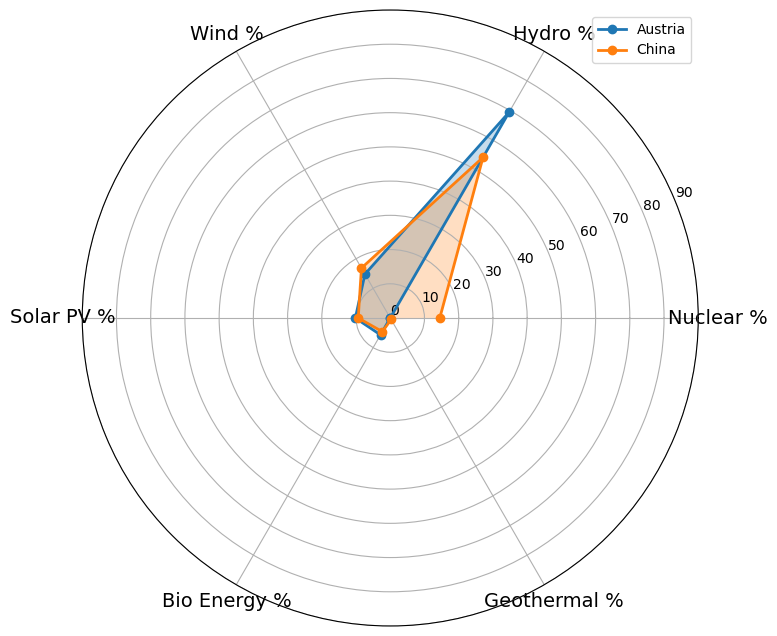

In [10]:
plot_similar_country(df_renewable, china_renewable)
